# Appendix A
## Quantum Dynamics of the TFIM using Trotterization and Constant-Depth Circuits

This notebook demonstrates how to generate constant-depth circuits for dynamic simulation of the transverse field Ising model (TFIM). First, circuits for different time-steps are prepared using Suzuki-Trotter decomposition. These circuits are then transformed into constant-depth circuits with optimized parameters for the given range of time-steps. 

The concept of constant-depth circuits was originally proposed in the [Constant-depth circuits for dynamic simulations of materials on quantum computers](https://jmsh.springeropen.com/articles/10.1186/s41313-022-00043-x) paper.

The number of spins in the chain (number of qubits) is arbitrary. The complete code is available on [Github](https://github.com/pranavi-jain/pennylane/tree/main/Heisenberg%20Model%20Dynamics).

### Import necessary libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from scipy.linalg import norm

# Qiskit import
import qiskit as qc
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

# Pennylane import
import pennylane as qml

### System parameters
Defining the parameters of the system and the simulation we wish to run. Here, we will be performing a quantum quench of a TFIM. Set the number of desired qubits; the coupling constant Jx; the strength and frequency of the transverse field hz and freq, respectively; the time-step size; the number of time-steps; and the number of shots for performing experiments on the quantum simulator or the real quantum hardware.

In [84]:
## Define simulation parameters for TFIM

N = 5  # number of spins/qubits

# TFIM Simulation parameters
Jx = 0.01183898         # coupling strength, in meV
hz = 2.0 * Jx           # transverse field strength, in meV   
freq = 0.0048           # frequency of the transverse field, in (1/fs)
delta_t = 3             # time-step size, in fs
num_steps = 40          # number of time-steps
shots = 8192            # number of shots for circuit execution

### Instantiate a Qiskit Runtime Service to run code on IBM hardware

In [3]:
from key import token_520, token_513

instance_520 = "usc/ee520-g/ee520-project"
instance_513 = "usc/phys513/phys513p"


## Define qiskit runtime service and backends

QiskitRuntimeService.save_account(channel="ibm_quantum", token=token_513, overwrite=True)

# To access saved credentials for the IBM quantum channel and select an instance
service = QiskitRuntimeService(channel="ibm_quantum", instance=instance_513)
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=N)
print(f"Using backend: {backend}")

Using backend: <IBMBackend('ibm_strasbourg')>


### Define the required simulators and QPU devices for pennylane

In [87]:
## Define the pennylane devices

dev_qubit = qml.device("default.qubit", wires=N)
dev_mixed = qml.device("default.mixed", wires=N)
dev_lightning = qml.device('lightning.qubit', wires=N) 
# dev_gpu = qml.device('lightning.gpu', wires=N) 
dev_aer = qml.device("qiskit.remote", wires=N, backend=AerSimulator())
# dev_qiskit = qml.device("qiskit.remote", wires=N, backend=backend, resilience_level=1, optimization_level=1)

### Instantiate global variables to store final results

In [85]:
## Define global variables to store Trotter and constant-depth results

trotter_sim_results = []
trotter_sim_cnots = []
trotter_aer_sim_results = []
trotter_aer_sim_cnots = []
trotter_ibm_results = []
trotter_ibm_cnots = []

cd_sim_results = []
cd_sim_cnots = []
cd_aer_sim_results = []
cd_aer_sim_cnots = []
cd_ibm_results = []
cd_ibm_cnots = []

## Dynamics simulation using Trotterization
In this section, we generate high-level circuits using Suzuki-Trotter decomposition and simulate the dynamics of TFIM. These circuits will also be used to create the constant-depth circuits. As expected, these circuits will not be constant in depth with increasing numbers of time-steps.

### Defining function to generate trotter circuits for different time-steps

In [47]:
from helper import evolution_circuit_TFIM


## Define the Trotter circuit for the TFIM Hamiltonian

def trotter_ckt(t, Jx, hz, freq, delta_t, N):
    # initial state is ground state of XX
    for q in range(0, N):
        qml.Hadamard(q)
    # circuit for evolution under the TFIM Hamiltonian
    evolution_circuit_TFIM(t, Jx, hz, freq, delta_t, N)
    # measuring the expectation value of the PauliX operators
    return [qml.expval(qml.PauliX(wires=i)) for i in range(N)]

(<Figure size 2400x600 with 1 Axes>, <Axes: >)

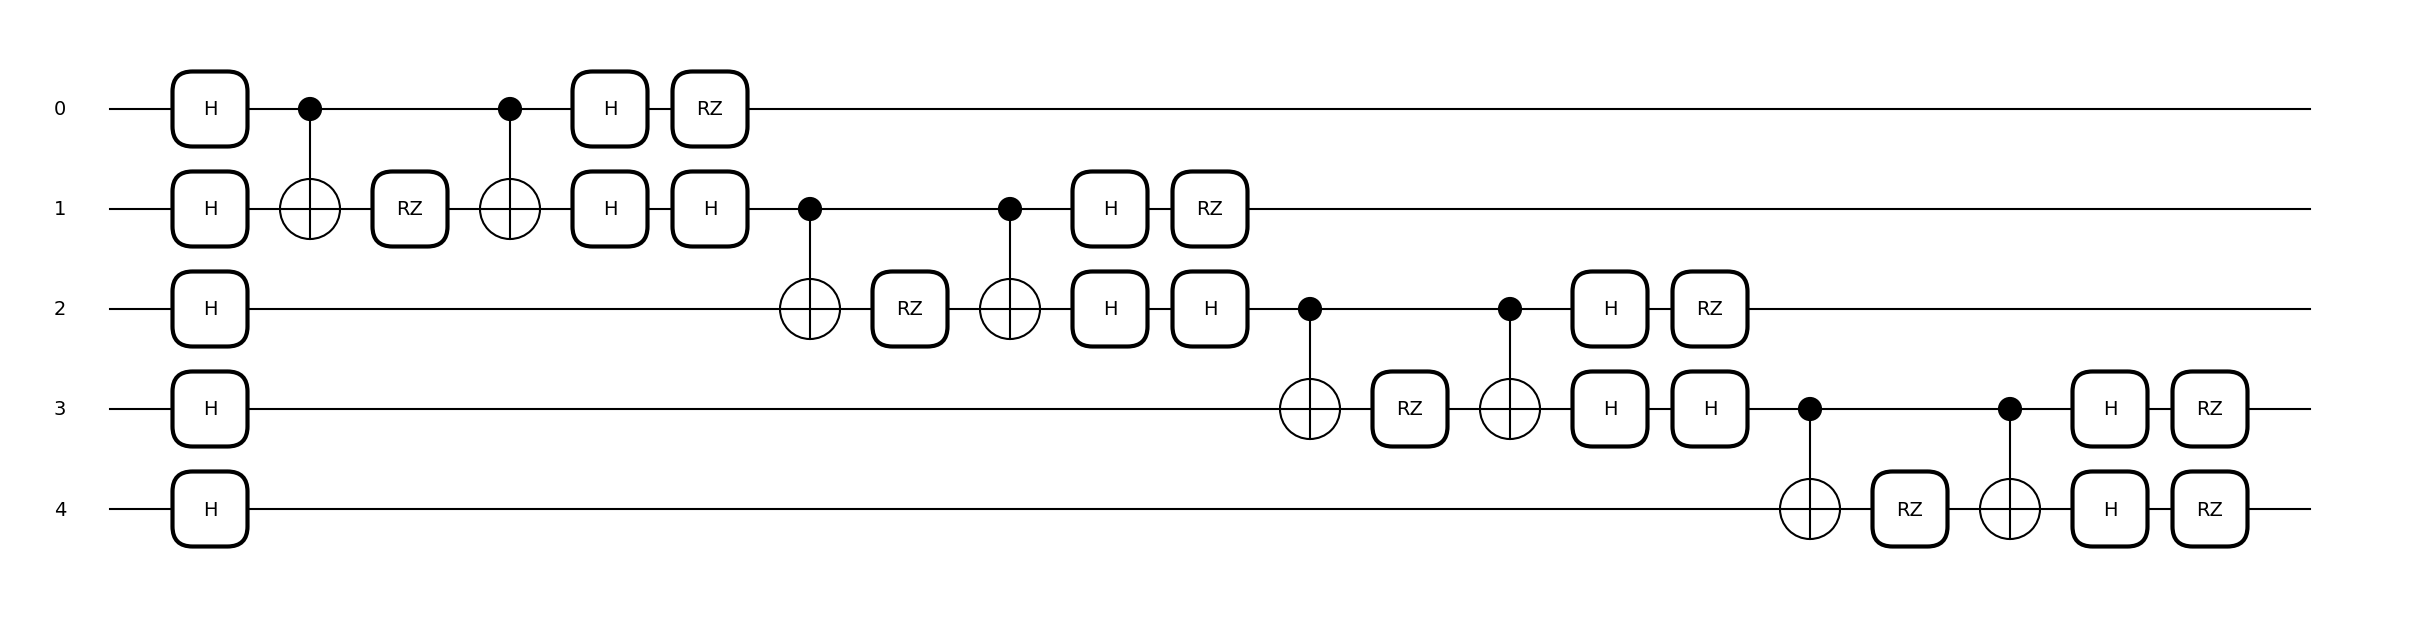

In [92]:
## Drawing a circuit for a single time-step of the TFIM Hamiltonian Simulation

qml.draw_mpl(evolution_circuit_TFIM)(1, Jx, hz, freq, delta_t, N)

### Simulating trotter circuit on Pennylane's default-qubit simulator

In [88]:
## Simulating the TFIM Hamiltonian using Trotter decomposition

trotter_sim_results = []    # Reinitialize the results list
trotter_sim_cnots = []  # Reinitialize the CNOT counts list
target_unitaries = []
trotter_sim_ckt = qml.QNode(trotter_ckt, device=dev_qubit)


for t in range(num_steps + 1):
    # Generate target unitary matrix for given time step
    target_unitaries.append(qml.matrix(trotter_sim_ckt)(t, Jx, hz, freq, delta_t, N))
    # Simulate the Trotter circuit
    exp_vals = trotter_sim_ckt(t, Jx, hz, freq, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_sim_results.append(result)
    trotter_sim_cnots.append(qml.specs(trotter_sim_ckt)(t, Jx, hz, freq, delta_t, N)["resources"].gate_types['CNOT'])


print(trotter_sim_results)

[np.float64(0.9999999999999993), np.float64(0.9768443411931113), np.float64(0.9099089519431083), np.float64(0.8062536823469524), np.float64(0.676052487837165), np.float64(0.5307715241055597), np.float64(0.38146052151261256), np.float64(0.23751502655835433), np.float64(0.10602104583277216), np.float64(-0.008399892091982109), np.float64(-0.10340899901812788), np.float64(-0.1785866696184162), np.float64(-0.2349963369819646), np.float64(-0.2747431530824357), np.float64(-0.300569040535492), np.float64(-0.3155098624539179), np.float64(-0.3226263851770611), np.float64(-0.3248055629922818), np.float64(-0.3246149138536611), np.float64(-0.3241846289580077), np.float64(-0.32509294523365206), np.float64(-0.32824168898488437), np.float64(-0.333729858908745), np.float64(-0.34075932795146496), np.float64(-0.3476291574763312), np.float64(-0.3518801796084877), np.float64(-0.3506261147056541), np.float64(-0.34104806845883223), np.float64(-0.32095265469313994), np.float64(-0.28923873777181475), np.float6

### Simulating trotter circuits on IBM's Aer_Simulator

In [89]:
## Simulating the TFIM Hamiltonian using Trotter decomposition - Qiskit AerSimulator

trotter_aer_sim_results = []   # Reinitialize the results list
trotter_aer_sim_cnots = []  # Reinitialize the CNOT counts list
trotter_aer_sim_ckt = qml.QNode(trotter_ckt, device=dev_aer)


for t in range(num_steps + 1):
    # Simulate the Trotter circuit
    exp_vals = trotter_aer_sim_ckt(t, Jx, hz, freq, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_aer_sim_results.append(result)
    trotter_aer_sim_cnots.append(qml.specs(trotter_aer_sim_ckt)(t, Jx, hz, freq, delta_t, N)["resources"].gate_types['CNOT'])

print(trotter_sim_results)

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If t

[np.float64(0.9999999999999993), np.float64(0.9768443411931113), np.float64(0.9099089519431083), np.float64(0.8062536823469524), np.float64(0.676052487837165), np.float64(0.5307715241055597), np.float64(0.38146052151261256), np.float64(0.23751502655835433), np.float64(0.10602104583277216), np.float64(-0.008399892091982109), np.float64(-0.10340899901812788), np.float64(-0.1785866696184162), np.float64(-0.2349963369819646), np.float64(-0.2747431530824357), np.float64(-0.300569040535492), np.float64(-0.3155098624539179), np.float64(-0.3226263851770611), np.float64(-0.3248055629922818), np.float64(-0.3246149138536611), np.float64(-0.3241846289580077), np.float64(-0.32509294523365206), np.float64(-0.32824168898488437), np.float64(-0.333729858908745), np.float64(-0.34075932795146496), np.float64(-0.3476291574763312), np.float64(-0.3518801796084877), np.float64(-0.3506261147056541), np.float64(-0.34104806845883223), np.float64(-0.32095265469313994), np.float64(-0.28923873777181475), np.float6

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


### Running trotter circuits on IBM Backends

In [ ]:
## Simulating the TFIM Hamiltonian using Trotter decomposition - IBM Backend

trotter_ibm_results = []   # Reinitialize the results list
trotter_ibm_cnots = []  # Reinitialize the CNOT counts list
trotter_ibm_ckt = qml.QNode(trotter_ckt, device=dev_qiskit)


'''TBD: Define session and collect job ids'''
for t in range(num_steps + 1):
    # Simulate the Trotter circuit
    exp_vals = trotter_ibm_ckt(t, Jx, hz, freq, delta_t, N)
    # Taking the mean of the expectation values = average magnetization
    result = np.mean(exp_vals)
    # Store the results
    trotter_ibm_results.append(result)
    trotter_ibm_cnots.append(qml.specs(trotter_ibm_ckt)(t, Jx, hz, freq, delta_t, N)["resources"].gate_types['CNOT'])

print(trotter_sim_results)

## Dynamics simulation using constant-depth circuits
In this section, we generate constant-depth circuits for the given range of time-steps and simulate the dynamics of TFIM. These curcuits use matchgates and as expected, these circuits are constant in depth with increasing numbers of time-steps.

### Define functions to generate circuits using matchgates
The structure of these matchgate circuits is adopted from the Appendix given in the [Constant-depth circuits for dynamic simulations of materials on quantum computers](https://jmsh.springeropen.com/articles/10.1186/s41313-022-00043-x) paper.

In [90]:
from matchgates_tfim import make_layertype1, make_layertype2


## Define the matchgate circuit for N qubits

def make_MGC(N, params):
    for l in range(N):
        # add layer_type1
        if l % 2 == 0:
            make_layertype1(N, params)
        # add layer_type2
        else:
            make_layertype2(N, params)
    return [qml.expval(qml.PauliX(wires=i)) for i in range(N)]

0: ──RZ(0.10)──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RZ(0.10)──RZ(0.10)──RX(1.57)──────────────── ···
1: ──RZ(0.10)──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RZ(0.10)──RZ(0.10)──RX(1.57)─╭●──RX(0.10)─╭● ···
2: ──RZ(0.10)──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RZ(0.10)──RZ(0.10)──RX(1.57)─╰X──RZ(0.10)─╰X ···
3: ──RZ(0.10)──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RZ(0.10)──RZ(0.10)──RX(1.57)──────────────── ···

0: ··· ──────────────────────────────────────────╭●──RX(0.10)─╭●──RX(-1.57)──RZ(0.10)────────── ···
1: ··· ──RX(-1.57)──RZ(0.10)──RZ(0.10)──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RZ(0.10)──RZ(0.10) ···
2: ··· ──RX(-1.57)──RZ(0.10)──RZ(0.10)──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RZ(0.10)──RZ(0.10) ···
3: ··· ──────────────────────────────────────────╰X──RZ(0.10)─╰X──RX(-1.57)──RZ(0.10)────────── ···

0: ··· ────────────────────────────────────────────────┤  <X>
1: ··· ──RX(1.57)─╭●──RX(0.10)─╭●──RX(-1.57)──RZ(0.10)─┤  <X>
2: ··· ──RX(1.57)─╰X──RZ(0.10)─╰X──RX(-1.57)──RZ(0.10)─┤  <X>
3: ··· ─

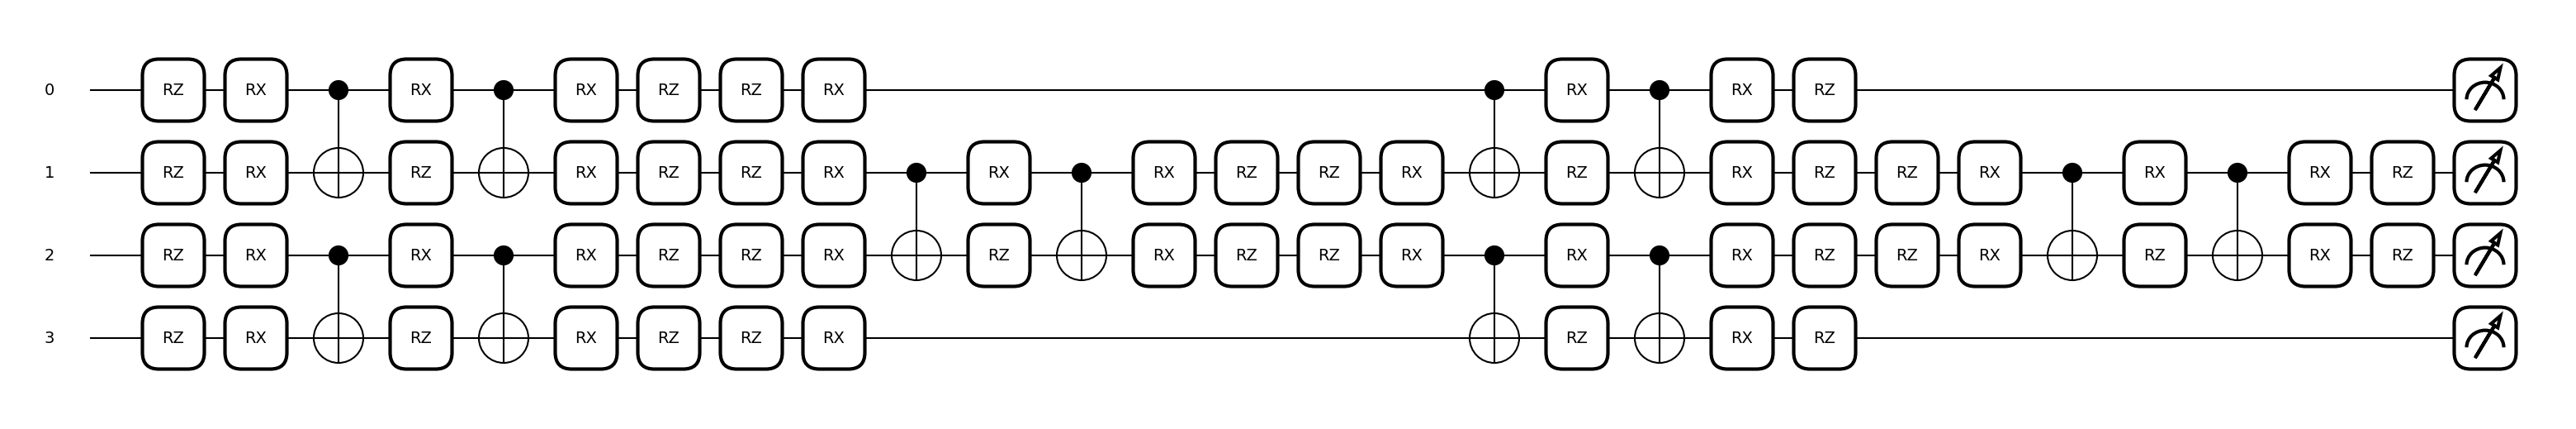

In [91]:
## Draw a matchgate circuit with random parameters (Testing)

print(qml.draw(make_MGC)(4, [0.1] * 4))     # draw() shows the parameter values
print(qml.draw_mpl(make_MGC)(4, [0.1] * 4))

### Optimize parameters and generate constant-depth circuits for all time-steps
The constant-depth circuits are generated by using optimal parameters for the matchgate circuits. The parameters are optimizated by minimizing a cost function that compares the distance between two unitary matrices - a target unitary obtained from high-level trotter circuits, and a unitary matrix obtained from the matchgate circuit structure.

In [93]:
## Define the cost function caluclating the distance (= 1 - fidelity) between 
## the target and current unitary matrices

matchgate_ckt = qml.QNode(make_MGC, device=dev_qubit)


def cost_function(params):
    current_unitary = qml.matrix(matchgate_ckt)(N, params)
    ## Calculate Frobenius distance
    # distance = norm(target_unitary - current_unitary, 'fro')
    distance = np.abs(
        1 - np.abs(np.sum(np.multiply(current_unitary, np.conj(target_unitary))))
        / current_unitary.shape[0]
    )
    return distance

In [108]:
## Find the best parameters for matchgates for each time step

num_runs = 5  # How many times minimization is repeated
tolerance = 1e-10  # Target final distance
final_params = []


for t in range(num_steps + 1):
    target_unitary = target_unitaries[t]    # Calculated during trotter circuit construction

    # Set the initial parameters
    init_params = [np.pi] * 4
    best_distance = np.inf
    best_params = None

    # Multi-start optimization loop
    for _ in range(num_runs):
        # Random initial guess
        # init_params = 2 * np.pi * (np.random.rand(len(init_params)) - 0.5)
        # init_params = np.array([random.random() for _ in range(len(init_params))])

        # Initial guess
        if best_params is not None:
            init_params = best_params

        # Minimize the cost function
        result = minimize(cost_function, init_params, tol=tolerance)  # default method

        if result.fun < best_distance:
            best_distance = result.fun
            best_params = result.x

        # Early stopping
        if best_distance < tolerance:
            break

    # Save the best found parameters
    final_params.append(best_params)
    print(f"Time step {t}: best achieved params at tolerance {best_distance:.2e}")

Time step 0: best achieved params 9.67e-01
Time step 1: best achieved params 9.57e-01
Time step 2: best achieved params 9.47e-01
Time step 3: best achieved params 9.38e-01
Time step 4: best achieved params 9.20e-01
Time step 5: best achieved params 9.06e-01
Time step 6: best achieved params 8.94e-01
Time step 7: best achieved params 8.86e-01
Time step 8: best achieved params 8.81e-01
Time step 9: best achieved params 9.29e-01
Time step 10: best achieved params 8.77e-01
Time step 11: best achieved params 8.75e-01
Time step 12: best achieved params 8.74e-01
Time step 13: best achieved params 8.73e-01
Time step 14: best achieved params 8.74e-01
Time step 15: best achieved params 8.76e-01
Time step 16: best achieved params 8.81e-01
Time step 17: best achieved params 8.86e-01
Time step 18: best achieved params 8.92e-01
Time step 19: best achieved params 8.97e-01
Time step 20: best achieved params 9.28e-01
Time step 21: best achieved params 9.34e-01
Time step 22: best achieved params 9.25e-0

In [103]:
## Define function to generate constant-depth circuits

def constant_depth_circuit(N, params):
    # initial state is ground state of XX
    for q in range(0, N):
        qml.Hadamard(q)
    # add matchgate circuit
    for l in range(N):
        # add layer_type1
        if l % 2 == 0:
            make_layertype1(N, params)
        # add layer_type2
        else:
            make_layertype2(N, params)
    return [qml.expval(qml.PauliX(wires=i)) for i in range(N)]

### Simulating and executing constant-depth circuits on the following devices:
1. Pennylane's default-qubit simulator
2. IBM's Aer_Simulator
3. IBM's Backend (QPU)

In [109]:
## Define function to get results from the constant-depth circuits

def get_results(ckt, N, final_params, num_steps):
    results = []
    cnots = []
    for t in range(num_steps + 1):
        # Simulate the constant-depth circuit
        exp_vals = ckt(N, final_params[t])
        # Taking the mean of the expectation values = average magnetization
        result = np.mean(exp_vals)
        results.append(result)
        cnots.append(qml.specs(ckt)(N, final_params[t])["resources"].gate_types['CNOT'])
    return results, cnots

In [110]:
## 1. Simulating the constant-depth circuits for given time-steps on pennylane simulator

cd_sim_results = []   # Reinitialize the results list
cd_sim_cnots = []  # Reinitialize the CNOT counts list
cd_sim_ckt = qml.QNode(constant_depth_circuit, device=dev_qubit)

cd_sim_results, cd_sim_cnots = get_results(cd_sim_ckt, N, final_params, num_steps)

print(cd_sim_results)

[np.float64(0.06061254432872561), np.float64(0.0007062770262932005), np.float64(-0.06735189407934494), np.float64(-0.11285670274890991), np.float64(-0.11203347710768034), np.float64(-0.05556053860854922), np.float64(0.008871041291895887), np.float64(0.07715322206827181), np.float64(0.1511539184432195), np.float64(-0.14675405010628886), np.float64(0.323654911459577), np.float64(0.41327731923638195), np.float64(0.4860347993638059), np.float64(0.5324039484888712), np.float64(0.5577981222645584), np.float64(0.5685106809039269), np.float64(0.5663712897642966), np.float64(0.5483982120131435), np.float64(0.49190378736159346), np.float64(0.34930945378218714), np.float64(-0.12070368959138292), np.float64(0.10137403790558279), np.float64(-0.09544011220725876), np.float64(-0.08635138497449138), np.float64(-0.08093518131719246), np.float64(-0.07862793510440484), np.float64(-0.07681983240184868), np.float64(-0.06937086249080764), np.float64(-0.046739647348918), np.float64(-0.008454489468771342), np

In [111]:
## 2. Simulating the constant-depth circuits on IBM AerSimulator

cd_aer_sim_results = []   # Reinitialize the results list
cd_aer_sim_cnots = []  # Reinitialize the CNOT counts list
cd_aer_sim_ckt = qml.QNode(constant_depth_circuit, device=dev_aer)

cd_aer_sim_results, cd_aer_sim_cnots = get_results(cd_aer_sim_ckt, N, final_params, num_steps)

print(cd_aer_sim_results)

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If t

[np.float64(0.05859375), np.float64(0.004296875), np.float64(-0.067578125), np.float64(-0.109765625), np.float64(-0.118359375), np.float64(-0.044921875), np.float64(0.013671875), np.float64(0.088671875), np.float64(0.13828125), np.float64(-0.157421875), np.float64(0.333984375), np.float64(0.447265625), np.float64(0.499609375), np.float64(0.518359375), np.float64(0.538671875), np.float64(0.5765625), np.float64(0.56171875), np.float64(0.563671875), np.float64(0.4875), np.float64(0.335546875), np.float64(-0.12734375), np.float64(0.0875), np.float64(-0.089453125), np.float64(-0.079296875), np.float64(-0.085546875), np.float64(-0.067578125), np.float64(-0.085546875), np.float64(-0.07265625), np.float64(-0.046484375), np.float64(-0.01171875), np.float64(0.208203125), np.float64(0.19921875), np.float64(0.107421875), np.float64(0.005078125), np.float64(-0.08125), np.float64(-0.2265625), np.float64(-0.3359375), np.float64(-0.428125), np.float64(-0.42578125), np.float64(-0.40625), np.float64(-0.

/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/pranavij/pennylane/.venv/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:292: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


In [ ]:
## 3. Simulating the constant-depth circuits on IBM Backend

cd_ibm_results = []   # Reinitialize the results list
cd_ibm_cnots = []  # Reinitialize the CNOT counts list
cd_ibm_ckt = qml.QNode(constant_depth_circuit, device=dev_qiskit)

'''TBD: Define session and collect job ids'''
cd_ibm_results, cd_ibm_cnots = get_results(cd_ibm_ckt, N, final_params, num_steps)

print(cd_ibm_results)

## Plot Results
In this section, we plot the following results:
1. Average Magnetization vs. Time-steps,
2. Number of CNOTS in circuit vs. Time-steps.
A single time-step is equal to **3fs**.

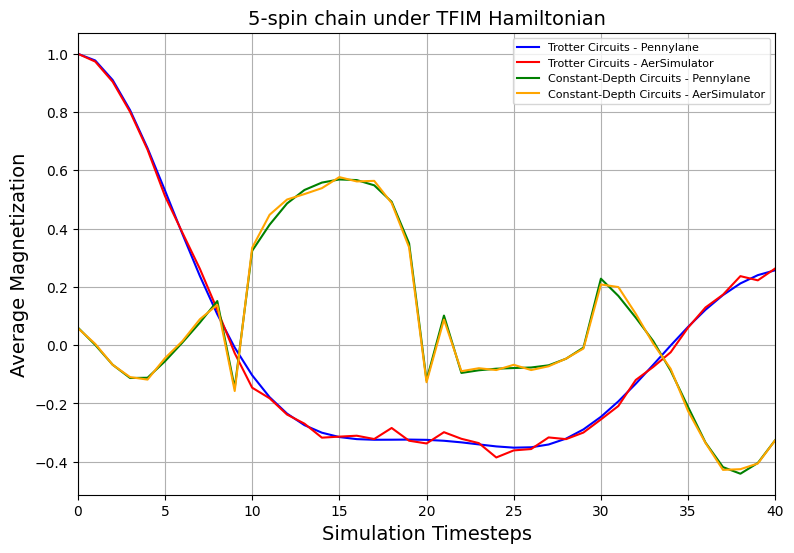

In [116]:
## Plotting the results - Average Magnetization vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_sim_results, label="Trotter Circuits - Pennylane", color="blue")
plt.plot(trotter_aer_sim_results, label="Trotter Circuits - AerSimulator", color="red")
# plt.plot(trotter_ibm_results, label=f"Trotter Circuits - {backend}", color="red")
plt.plot(cd_sim_results, label="Constant-Depth Circuits - Pennylane", color="green")
plt.plot(cd_aer_sim_results, label="Constant-Depth Circuits - AerSimulator", color="orange")
plt.xlim(0,num_steps)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Average Magnetization", fontsize=14)
plt.title(f"{N}-spin chain under TFIM Hamiltonian", fontsize=14)
plt.grid()
plt.legend(fontsize=8)
plt.show()
# plt.savefig(f'{N}q_TFIM_sim_pennylane.svg', dpi=500)

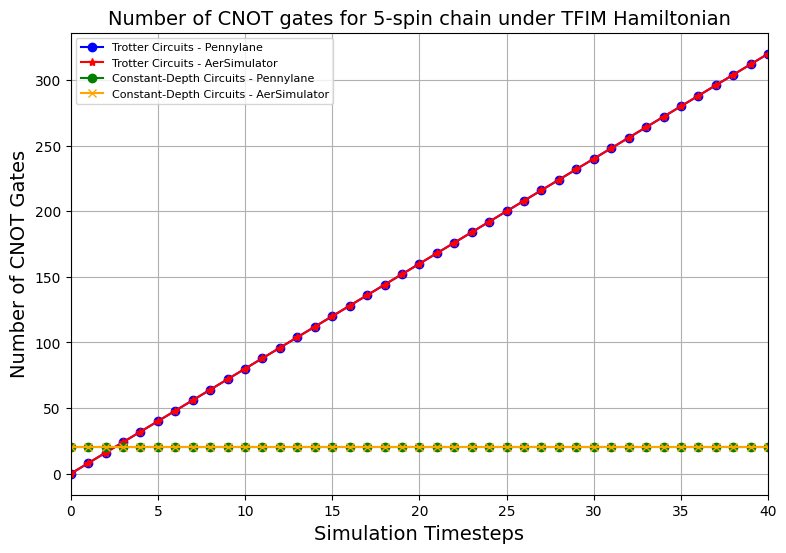

In [ ]:
## Plotting the circuit depth vs. time-steps

plt.figure(figsize=(9, 6))
plt.plot(trotter_sim_cnots, label="Trotter Circuits - Pennylane", color="blue", marker="o")
plt.plot(trotter_aer_sim_cnots, label="Trotter Circuits - AerSimulator", color="red", marker="*")
# plt.plot(trotter_ibm_cnots, label=f"Trotter Circuits - {backend}", color="red")
plt.plot(cd_sim_cnots, label="Constant-Depth Circuits - Pennylane", color="green", marker="o")
plt.plot(cd_aer_sim_cnots, label="Constant-Depth Circuits - AerSimulator", color="orange", marker="x")
plt.xlim(0, num_steps)
# plt.ylim(-1.0, 1.0)
plt.xlabel("Simulation Timesteps", fontsize=14)
plt.ylabel("Number of CNOT Gates", fontsize=14)
plt.title(f"Number of CNOT gates for {N}-spin chain under TFIM Hamiltonian", fontsize=14)
plt.legend(fontsize=8)
plt.grid()
plt.show()

<hr/>